# Social Network

In [1]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import plotly.graph_objects as go
import logging

In [2]:
rc("animation", html="jshtml")

## Function Definitions


In [3]:
def cosine_similarity(post_atribute_distribution, agent_atribute_preference):
    all_atributes_items = set(agent_atribute_preference.keys()).union(set(post_atribute_distribution.keys()))

    # Create vectors from the dictionaries, ensuring missing topics are assigned a probability of 0
    agent_vector = np.array([agent_atribute_preference.get(atribute_item, 0) for atribute_item in all_atributes_items])
    post_vector = np.array([post_atribute_distribution.get(atribute_item, 0) for atribute_item in all_atributes_items])

    # Calculate the cosine similarity
    cosine_similarity = np.dot(agent_vector, post_vector) / (np.linalg.norm(agent_vector) * np.linalg.norm(post_vector))
    return cosine_similarity

## Class definitions

In [4]:
class Post:
    def __init__(self, author, text, topic_distribution, sentiment_distribution):
        self.author = author
        self.text = text
        self.topic_distribution = topic_distribution
        self.sentiment_distribution = sentiment_distribution
        self.post_content_string = f"{self.author} posted: {self.text} {self.topic_distribution} being {self.sentiment_distribution}"
        self.viewed = []
        
        logger.info(self.post_content_string)
        
    def __repr__(self):
        return self.post_content_string
    
    def add_viewed(self, agent):
        self.viewed.append(agent)

In [5]:
class Agent:
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        self.agent_id = agent_id
        self.followers = followers if followers else []
        self.following = []
        self.topic_preference = topic_preference if topic_preference else {}
        self.sentiment_preference = sentiment_preference if sentiment_preference else {}
        self.post_history = []

    def tweet(self, content):
        post = Post(author = self.agent_id,
                    text = content["text"],
                    topic_distribution = content["topic_distribution"],
                    sentiment_distribution = content["sentiment_distribution"])
        self.post_history.append(post)
        return post

    def add_follower(self, follower_agent):
        self.followers.append(follower_agent)

    def follow(self, agent):
        self.following.append(agent)
        agent.add_follower(self)
        
    def remove_follower(self, follower_agent):
        self.followers.remove(follower_agent)
        
    def unfollow(self, agent):
        self.following.remove(agent)
        agent.remove_follower(self)
        
    def engage_with_post(self, post):#THIS SHOULD BE MORE OPTIMIZED.
        # Calculate engagement chance based on overlapping topics and probabilities
        cosine_similarities = []
        cosine_similarities.append(cosine_similarity(post.topic_distribution, self.topic_preference))
        cosine_similarities.append(cosine_similarity(post.sentiment_distribution, self.sentiment_preference))
        
        normalized_cosine_similarities = np.divide(cosine_similarities, len(cosine_similarities)) #this gives every atribute the same importance... not sure
        normalized_cosine_similarities_sum = sum(normalized_cosine_similarities)
        
        positive_engagement_chance = normalized_cosine_similarities_sum * self.engagement_rate
                
        negative_engagement_rate = 0.05 # negative, hate, ofensive... TO BE DEFINED! Probably per cluster
        negative_engagement_chance = (1-normalized_cosine_similarities_sum) * negative_engagement_rate
              
        if (random.random() < positive_engagement_chance):
            action = random.choices(["like", "retweet", "comment"], [0.7,0.1,0.2])[0] #Calibrate to real data!
            engagement_type = "positive"
            logger.info(f"    {self.agent_id} {action}d post by {post.author} [et={engagement_type}, pec={round(positive_engagement_chance,2)}, cs={round(normalized_cosine_similarities_sum,2)}]")
            return action, engagement_type
        elif (random.random() < negative_engagement_chance):
            action = random.choice(["comment"])
            engagement_type = "negative"
            logger.info(f"    {self.agent_id} {action}d post by {post.author} [et={engagement_type}, nec={round(negative_engagement_chance,2)}, cs={round(normalized_cosine_similarities_sum,2)}]")
            return action, engagement_type
        return None, None


class Influencer(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference)
        self.type = 'Influencer'
        self.posting_frequency = 0.7
        self.engagement_rate = 0.3
        self.follow_rate = 0.1
        self.unfollow_rate = 0.1

class Sharer(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference)
        self.type = 'Sharer'
        self.posting_frequency = 0.2
        self.engagement_rate = 0.5
        self.follow_rate = 0.5
        self.unfollow_rate = 0.1

class StandardUser(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference)
        self.type = 'StandardUser'
        self.posting_frequency = 0.1
        self.engagement_rate = 0.1
        self.follow_rate = 0.2
        self.unfollow_rate = 0.1

In [6]:
class SocialNetwork:
    def __init__(self):
        self.agents_set = {}
        self.graph = nx.DiGraph()

    def add_agent(self, agent):
        self.agents_set[agent.agent_id] = agent
        self.graph.add_node(agent.agent_id, type=agent.type) 

    def create_followers(self, agent_id, follower_ids):
        agent = self.agents_set[agent_id]
        for fid in follower_ids:
            if fid in self.agents_set:
                follower = self.agents_set[fid]
                follower.follow(agent)
                self.graph.add_edge(fid, agent_id, action='follow')

    def propagate_post(self, writer, post):
        author = self.agents_set[post.author]
        for follower in writer.followers:
            if (follower not in post.viewed) and (follower != author):
                post.add_viewed(follower)
                action, engagement_type = follower.engage_with_post(post)
                if action:
                    try:
                        self.graph[follower.agent_id][author.agent_id]['action'] = action
                    except:
                        logging.warning(f"        Edge [{follower.agent_id}][{author.agent_id}] does not exist. Action {action} won't appear in the animation")  
                    if (engagement_type=="positive") and (random.random() < follower.follow_rate) and (follower not in author.followers):
                        follower.follow(author)
                        self.graph.add_edge(follower.agent_id, post.author, action='follow')
                        logger.info(f"    {follower.agent_id} started following {post.author} :)")
                    elif (engagement_type=="negative") and (random.random() < follower.unfollow_rate): #Right now comments the author and unfollows the writer. Interaction to be better defined. (twitter knowledge: can you comment a retweet? would you unfollow both in this case? etc.)
                        follower.unfollow(writer)
                        self.graph.remove_edge(follower.agent_id, writer.agent_id)
                        logger.info(f"    {follower.agent_id} stopped following {writer.agent_id} :(")
                    self.propagate_post(follower, post)
                
    def step(self):
        for agent_id, agent in self.agents_set.items():
            if random.random() < agent.posting_frequency:
                content = {
                    "text": "Tweet about",
                    "topic_distribution": agent.topic_preference,
                    "sentiment_distribution": agent.sentiment_preference,
                    # To do: modify a bit preferneces form post to post. Not all post should follow strictly the authors preferences.
                }
                post = agent.tweet(content)
                self.propagate_post(agent, post)
    
    def run_animation(self, n_steps):
        fig, ax = plt.subplots(figsize=(18, 12))
        pos = nx.spring_layout(self.graph)
        def visualize_network(step):
            logger.info("")
            logger.info(f"Step {step}")
            ax.clear()
            
            n_colors = {
                'Influencer': (1.0, 0.39, 0.28, 0.8),     # Tomato Red with 80% opacity
                'Sharer': (0.12, 0.56, 1.0, 0.8),         # Dodger Blue with 80% opacity
                'StandardUser': (0.13, 0.55, 0.13, 0.8)   # Forest Green with 80% opacity
            }
            node_colors = [n_colors[self.graph.nodes[node]['type']] for node in self.graph.nodes]
            node_sizes = [100 + 2000 * len(self.agents_set[node].followers) for node in self.graph.nodes]
            e_colors = {
                "like": (0.12, 0.56, 1.0, 0.8),           # Light Blue with 60% opacity
                "retweet": (1.0, 0.0, 0.5, 0.8),          # Magenta with 60% opacity
                "comment": (0.969, 0.439, 0.024, 0.8),    # Orange with 60% opacity
                "follow": (0.27, 0.27, 0.27, 0.8)         # Dark Grey with 60% opacity
            }
            edge_colors = [e_colors[self.graph.edges[edge]['action']] for edge in self.graph.edges]
            
            nx.draw_networkx(self.graph, pos, node_color=node_colors, node_size=node_sizes, edge_color=edge_colors, ax=ax, with_labels=True)
            nx.set_edge_attributes(self.graph, 'follow', 'action')
            ax.set_title(f'Social Network at Step {step}')
            ax.set_xticks([])
            ax.set_yticks([])
            network.step()
        return animation.FuncAnimation(fig, visualize_network, frames=n_steps, interval=500, repeat=True)

## A simple example

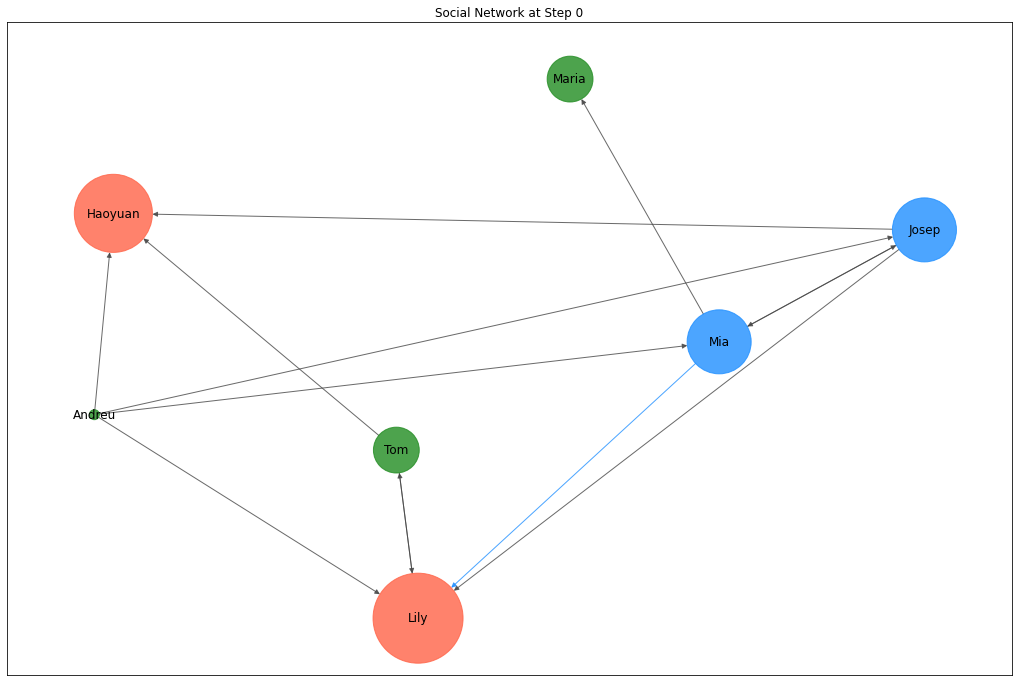

In [7]:
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='app.log', mode='w')
formatter = logging.Formatter('%(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)


network = SocialNetwork()

# Influencers
influencer1 = Influencer(
    "Haoyuan", 
    topic_preference={"tech": 0.7, "politics": 0.3},
    sentiment_preference={"negative": 0.2, "neutral": 0.3, "positive": 0.5}
)

influencer2 = Influencer(
    "Lily", 
    topic_preference={"lifestyle": 0.8, "fitness": 0.2},
    sentiment_preference={"negative": 0.1, "neutral": 0.4, "positive": 0.5}
)

# Sharers
sharer1 = Sharer(
    "Josep", 
    topic_preference={"lifestyle": 1.0},
    sentiment_preference={"negative": 0.1, "neutral": 0.5, "positive": 0.3}
)

sharer2 = Sharer(
    "Mia", 
    topic_preference={"lifestyle": 0.7, "fitness": 0.3},
    sentiment_preference={"negative": 0.1, "neutral": 0.5, "positive": 0.5}
)

# Standard Users
standard_user1 = StandardUser(
    "Andreu", 
    topic_preference={"lifestyle": 1.0},
    sentiment_preference={"negative": 0.3, "neutral": 0.3, "positive": 0.4}
)

standard_user2 = StandardUser(
    "Maria", 
    topic_preference={"science": 0.6, "politics": 0.4},
    sentiment_preference={"negative": 0.25, "neutral": 0.5, "positive": 0.25}
)

standard_user3 = StandardUser(
    "Tom", 
    topic_preference={"tech": 0.5, "travel": 0.5},
    sentiment_preference={"negative": 0.2, "neutral": 0.3, "positive": 0.5}
)


# Register agents in the network
network.add_agent(influencer1)
network.add_agent(influencer2)
network.add_agent(sharer1)
network.add_agent(sharer2)
network.add_agent(standard_user1)
network.add_agent(standard_user2)
network.add_agent(standard_user3)

# Create follower relationships
network.create_followers("Haoyuan", ["Josep", "Andreu", "Maria", "Tom"])
network.create_followers("Lily", ["Mia", "Andreu", "Tom"])

network.create_followers("Josep", ["Mia"])
network.create_followers("Mia", ["Josep", "Andreu"])

network.create_followers("Andreu", [])
network.create_followers("Maria", ["Mia"])
network.create_followers("Tom", ["Lily"])

network.run_animation(50)

**Print when he structure changes (following)**

In [8]:
with open("app.log", 'r') as f:
    lines = f.read().split('\nStep ')
    for line in lines:
        if "following" in line:
            print(line)

1
Haoyuan posted: Tweet about {'tech': 0.7, 'politics': 0.3} being {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5}
    Josep liked post by Haoyuan [et=positive, pec=0.22, cs=0.44]
Lily posted: Tweet about {'lifestyle': 0.8, 'fitness': 0.2} being {'negative': 0.1, 'neutral': 0.4, 'positive': 0.5}
    Mia commentd post by Lily [et=positive, pec=0.5, cs=0.99]
    Josep liked post by Lily [et=positive, pec=0.48, cs=0.95]
        Edge [Josep][Lily] does not exist. Action like won't appear in the animation
    Josep started following Lily :)
    Tom liked post by Lily [et=positive, pec=0.05, cs=0.49]

14
Haoyuan posted: Tweet about {'tech': 0.7, 'politics': 0.3} being {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5}
Lily posted: Tweet about {'lifestyle': 0.8, 'fitness': 0.2} being {'negative': 0.1, 'neutral': 0.4, 'positive': 0.5}
Josep posted: Tweet about {'lifestyle': 1.0} being {'negative': 0.1, 'neutral': 0.5, 'positive': 0.3}
    Mia liked post by Josep [et=positive, pec=0.47, cs=0

### Notes for the future

- Obviously calibrate model with real data.

- (DONE) Add negative actions such as unfollow.
- Define better when negative actions occurr. Is it good doing the (1-ncs)?
- (DONE) Add action comment.
- (DONE) Work with probabilities, a post should have multiple topics. cosine similarity.
- (DONE) Add sentiment preferences.
- (DONE) Make posts an object? and keep track that one can not like a post twice.
- Add other atributes.
- In general check again for possible infinite loops due to recursiveness.
- The way agents interact will be way more complex.
- Random choices could be substituted by reinforcement learning. Parameters to be modified will be the probabilities of the atributes and the rewards are likes and follows. Might converge or not, also no idea what I would expect to want.
- Atributes should have a temporal component?. Everything should have a temporal component? How would you do this?
- We will need to include a simple algorithm to recommend outside your network based on trending posts. Kind of an ´explore´. Also to sort your content feed.
- Include slacks and biases, not everything should be perfect.
- Periodical addition of new users.
- Consider Transfer between agent classes: Influencer canceled of standard becoming popular.
- (DONE) Create animation/better visualization of results. Color edges when something happens!
- Redirect output to log files.